### Cohort Retention Analysis
Cohort : 유사한 특성 (가입기간, 연령, 성별 등) 을 가진 집단<br>
Retention : AARRR의 'Retention' 단계는 사용자들이 서비스에 **다시** 방문하는가를 수치화하는 지표

즉, Cohort Retention이란 어떠한 특성을 가진 사용자 집단의 재방문 추이를 살펴볼 수 있는 분석 기법이다.

In [187]:
import pymysql
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import os
import time
from dotenv import load_dotenv
load_dotenv()
MYSQL_ROOT_PW = os.environ.get("MYSQL_ROOT_PW")
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [143]:
con = pymysql.connect(host="localhost", db="ecommerce", user="root", password=MYSQL_ROOT_PW)
cur = con.cursor()

In [123]:
def fetchresult_to_df(query):
    cur.execute(query)
    result = cur.fetchall()
    return pd.DataFrame(result)

In [124]:
try:
    query = """
    SELECT *
    FROM retail
    LIMIT 3;
    """
    df = fetchresult_to_df(query)
    df.columns = ["invoice_no", "stock_code", "description", "quantity",
                    "invoice_date", "unit_price", "customer_id", "country"]
    display(df)
except:
    print("SQL Server Connection Error!")

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom


In [125]:
# Retention chart를 생성하기 위한 column만을 추출한 View를 구성
# year + month => 월별 최초 구매가 발생한 customer의 이후 retention을 살펴보기 위함이다.
# YEAR(invoice_date), MONTH(invoice_date) 하지 않는 이유는, 각 년월(특히 월)의 format을 zero-padding 된 string으로 유지하기 위함이다.
# e.g.) "2022-03-08"을  MONTH(invoice_date) 하면 '3', SUBSTRING(invoice_date, 6, 2) 하면 '03'

try:
    query = """
    CREATE VIEW sales as 
    (
        SELECT substring(invoice_date, 1, 4) year,
             substring(invoice_date, 6, 2) month,
            customer_id,
            country,
            sum(quantity) quantity
        FROM retail
        GROUP BY 1, 2, 3, 4
    );
    """
    cur.execute(query)
except:
    print("SQL Server Connection Error!")

In [126]:
try:
    query = """
    SELECT *
    FROM SALES;
    """
    df = fetchresult_to_df(query)
    df.columns = ["year", "month", "customer_id", "country", "quantity"]
    display(df.head(3))
except:
    print("SQL Server Connection Error!")

,year,month,customer_id,country,quantity
0,2010,12,17850,United Kingdom,1733
1,2010,12,13047,United Kingdom,101
2,2010,12,12583,France,449


#### 1. Retention 계산을 위한 Year-Month Index 생성

특정 코호트로 분류된 사용자의 m+1, m+2, ... 구매 이력을 분류하기 위하여
시작년월 ~ 다음년월 간의 관계를 나타내는 index가 포함된 Base Year-Month View를 생성한다.

e.g.)

| customer | first_year | first_month | next_year | next_month | index (m+idx) |
|----------|------------|-------------|-----------|------------|---------------|
| Noel     | 2001       | 10          | 2001      | 12         | 2             |
| Noel     | 2002       | 02          | 2002      | 05         | 3             |
| Liam     | 2002      | 02          | 2002      | 07         | 5             |

In [128]:
try:
    query = """
    CREATE VIEW monthly_idx as
    (
        WITH distinct_ym as 
        (
            SELECT year, month
            FROM sales
            GROUP BY 1, 2
        )
        
        SELECT *,
            ROW_NUMBER() OVER(PARTITION BY first_ym order by next_ym) idx
        FROM (SELECT year first_year, month first_month, concat(year, month) first_ym from distinct_ym) A
            CROSS JOIN
            (SELECT year next_year, month next_month, concat(year, month) next_ym from distinct_ym) B
        WHERE first_ym <= next_ym
    );
    """
    cur.execute(query)
except:
    print("SQL Server Connection Error!")

In [129]:
try:
    query = """
    SELECT *
    FROM monthly_idx
    """
    df = fetchresult_to_df(query)
    df.columns = ["first_year", "first_month", "first_ym", "next_year", "next_month", "next_ym", "index"]
    display(df.head(5))
except:
    print("SQL Server Connection Error!")

,first_year,first_month,first_ym,next_year,next_month,next_ym,index
0,2010,12,201012,2010,12,201012,1
1,2010,12,201012,2011,01,201101,2
2,2010,12,201012,2011,02,201102,3
3,2010,12,201012,2011,03,201103,4
4,2010,12,201012,2011,04,201104,5


In [147]:
try:
    query = """
    CREATE VIEW sales_fin as
    (
        WITH first_CTE as (
            SELECT customer_id, min(CONCAT(year, month)) first_ym
            FROM sales
            GROUP BY 1
        )

        SELECT customer_id, year, month, F.first_ym, country, quantity, idx
        FROM sales S
            JOIN first_CTE F USING (customer_id)
            JOIN monthly_idx M 
                on F.first_ym = M.first_ym
                    and concat(S.year, S.month) = next_ym
    );
    """
    cur.execute(query)
except:
    print("SQL Server Connection Error!")

In [148]:
try:
    query = """
    SELECT *
    FROM sales_fin
    LIMIT 5;
    """
    df = fetchresult_to_df(query)
    df.columns = ["cutomer_id", "year", "month", "first_ym", "country", "quantity", "Index"]
    display(df)
except:
    print("SQL Server Connection Error!")

,cutomer_id,year,month,first_ym,country,quantity,Index
0,17850,2010,12,201012,United Kingdom,1733,1
1,13047,2010,12,201012,United Kingdom,101,1
2,13047,2011,02,201012,United Kingdom,211,3
3,13047,2011,03,201012,United Kingdom,193,4
4,13047,2011,05,201012,United Kingdom,176,6


#### 2. Retention 분석

In [157]:
# Cohort별(첫구매 기준 년월) Volume (idx = 1. 첫구매자) 

try:
    query = """
    SELECT CONCAT(year, month), COUNT(*)
    FROM sales_fin
    where idx = 1
    GROUP BY 1
    """
    df = fetchresult_to_df(query)
    df.columns = ["ym", "volume"]
except:
    print("SQL Server Connection Error!")

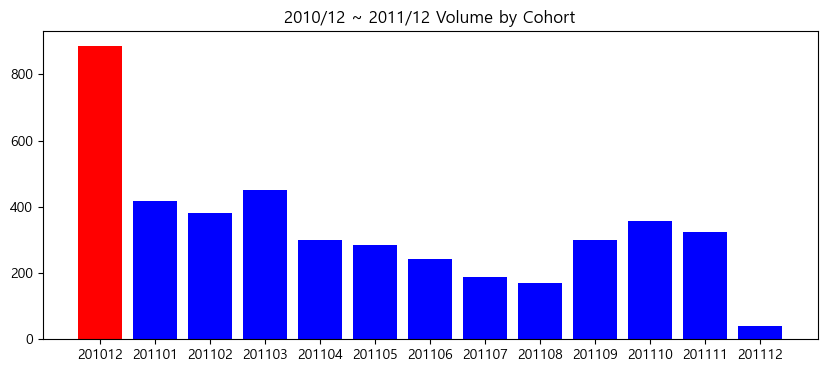

In [171]:
plt.figure(figsize=(10, 4))
plt.title("2010/12 ~ 2011/12 Volume by Cohort")
colors = ["red" if x == max(df["volume"]) else "blue" for x in df["volume"]]
plt.bar(df["ym"], df["volume"], color=colors)
plt.show()

In [232]:
# Retention Chart

try:
    query = """
    select first_ym,
        MAX(CASE WHEN idx = 1 THEN volume END) as volume,
        MAX(CASE WHEN idx = 2 THEN volume END) as M1,
        MAX(CASE WHEN idx = 3 THEN volume END) as M2,
        MAX(CASE WHEN idx = 4 THEN volume END) as M3,
        MAX(CASE WHEN idx = 5 THEN volume END) as M4,
        MAX(CASE WHEN idx = 6 THEN volume END) as M5,
        MAX(CASE WHEN idx = 7 THEN volume END) as M6,
        MAX(CASE WHEN idx = 8 THEN volume END) as M7,
        MAX(CASE WHEN idx = 9 THEN volume END) as M8,
        MAX(CASE WHEN idx = 10 THEN volume END) as M9,
        MAX(CASE WHEN idx = 11 THEN volume END) as M10,
        MAX(CASE WHEN idx = 12 THEN volume END) as M11,
        MAX(CASE WHEN idx = 13 THEN volume END) as M12
    FROM (
        SELECT first_ym, CONCAT(year, month) next_ym, idx, count(*) as volume
        FROM sales_fin
        GROUP BY 1,2,3
    ) VOLUME_TBL
    GROUP BY first_ym
    """
    df = fetchresult_to_df(query)
    df.columns = ["Cohort"] + ["Volume"] + [f"M+{x}" for x in range(1, 13)]
    df.set_index('Cohort', inplace=True)
    display(df)
except:
    print("SQL Server Connection Error!")

,Volume,M+1,M+2,M+3,M+4,M+5,M+6,M+7,M+8,M+9,M+10,M+11,M+12
Cohort,,,,,,,,,,,,,
201012,886,324.0,287.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,332.0,445.0,235.0
201101,417,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
201102,380,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
201103,452,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
201104,300,64.0,61.0,63.0,59.0,69.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
201105,284,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
201106,242,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
201107,188,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201108,169,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [233]:
df = df.iloc[:, 1:].apply(lambda x : x/df["Volume"])

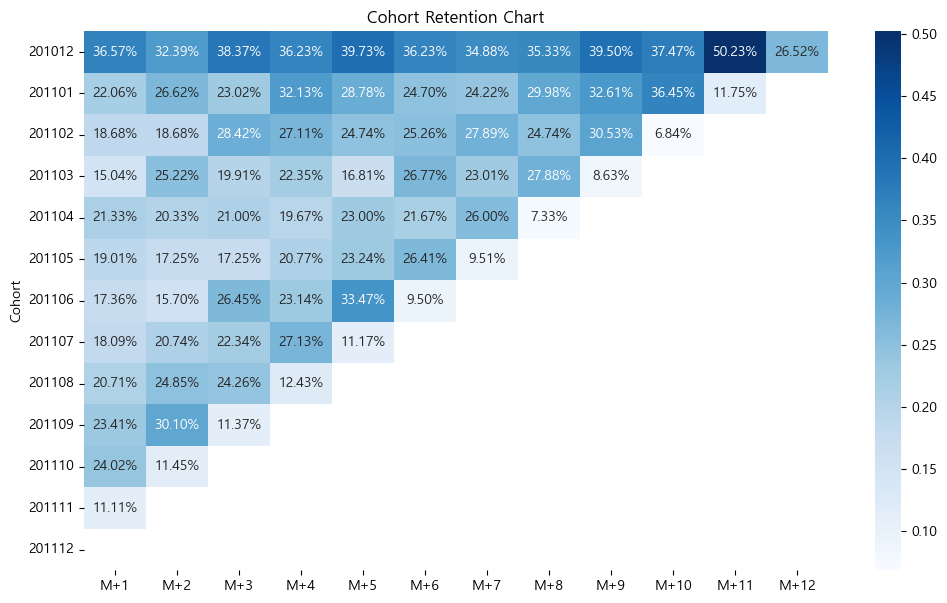

In [235]:
plt.figure(figsize=(12, 7))
plt.title("Cohort Retention Chart")
sns.heatmap(df, annot=True, fmt='.2%',cmap='Blues')
plt.show()